In [1]:
from keras.layers import Lambda, Input, Dense
from keras.models import Model
from keras.datasets import mnist
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model
from keras import backend as K

import numpy as np
import matplotlib.pyplot as plt
import argparse
import os


# reparameterization trick
# instead of sampling from Q(z|X), sample eps = N(0,I)
# z = z_mean + sqrt(var)*eps
def sampling(args):
    """Reparameterization trick by sampling fr an isotropic unit Gaussian.

    # Arguments
        args (tensor): mean and log of variance of Q(z|X)

    # Returns
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon


def plot_results(models,
                 data,
                 batch_size=128,
                 model_name="vae_mnist"):
    """Plots labels and MNIST digits as function of 2-dim latent vector

    # Arguments
        models (tuple): encoder and decoder models
        data (tuple): test data and label
        batch_size (int): prediction batch size
        model_name (string): which model is using this function
    """

    encoder, decoder = models
    x_test, y_test = data
    os.makedirs(model_name, exist_ok=True)

    filename = os.path.join(model_name, "vae_mean.png")
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = encoder.predict(x_test,
                                   batch_size=batch_size)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y_test)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.savefig(filename)
    plt.show()

    filename = os.path.join(model_name, "digits_over_latent.png")
    # display a 30x30 2D manifold of digits
    n = 30
    digit_size = 28
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-4, 4, n)
    grid_y = np.linspace(-4, 4, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit

    plt.figure(figsize=(10, 10))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap='Greys_r')
    plt.savefig(filename)
    plt.show()


# MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

image_size = x_train.shape[1]
original_dim = image_size * image_size
x_train = np.reshape(x_train, [-1, original_dim])
x_test = np.reshape(x_test, [-1, original_dim])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# network parameters
input_shape = (original_dim, )
intermediate_dim = 512
batch_size = 128
latent_dim = 2
epochs = 50


Using TensorFlow backend.


In [0]:
inputs = Input(shape=input_shape)
x = Dense(intermediate_dim, activation='relu')(inputs)
z_mean = Dense(latent_dim, activation='relu')(inputs)
z_var_log = Dense(latent_dim, activation='relu')(inputs)

z = Lambda(sampling, output_shape=(latent_dim, ))([z_mean, z_var_log])

encoder = Model(inputs, [z_mean, z_var_log , z])

latent_inputs = Input(shape=(latent_dim, ))
x = Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = Dense(original_dim, activation='sigmoid')(x)

decoder = Model(latent_inputs, outputs)

outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs)

Instructions for updating:
Use tf.cast instead.
Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 3s 57us/step - loss: 58.2294 - val_loss: 50.4921
Epoch 2/50
60000/60000 [==============================] - 2s 34us/step - loss: 49.9476 - val_loss: 49.6848
Epoch 3/50
60000/60000 [==============================] - 2s 34us/step - loss: 49.6665 - val_loss: 49.5574
Epoch 4/50
60000/60000 [==============================] - 2s 32us/step - loss: 49.5487 - val_loss: 49.4782
Epoch 5/50
60000/60000 [==============================] - 2s 30us/step - loss: 49.5012 - val_loss: 49.4566
Epoch 6/50
60000/60000 [==============================] - 2s 30us/step - loss: 49.4881 - val_loss: 49.4220
Epoch 7/50
60000/60000 [==============================] - 2s 31us/step - loss: 49.4154 - val_loss: 49.4083
Epoch 8/50
60000/60000 [==============================] - 2s 30us/step - loss: 49.3636 - val_loss: 49.4461
Epoch 9/50
60000/60000 [======================

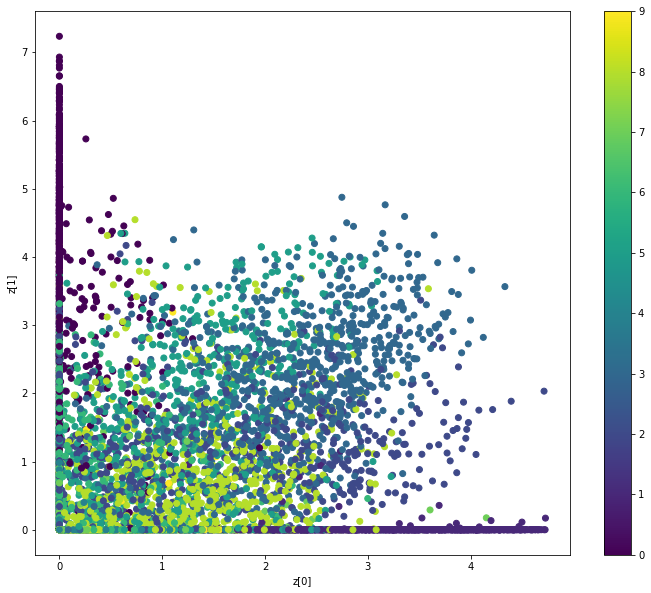

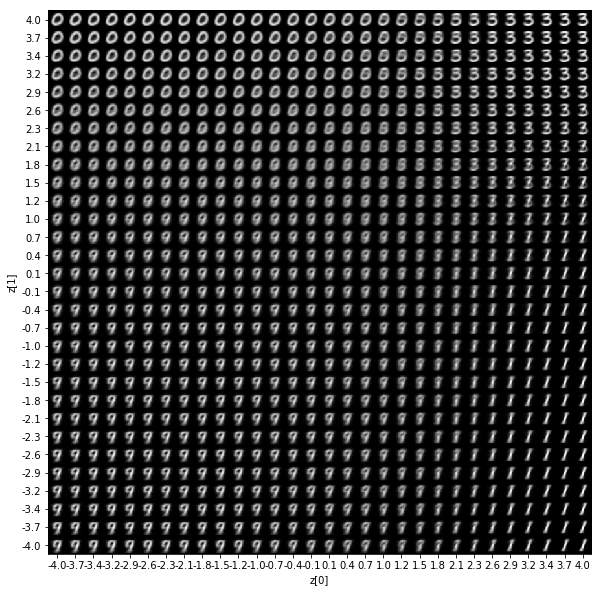

In [8]:
data = (x_test, y_test)

reconstruction_loss = mse(inputs, outputs)
reconstruction_loss *= original_dim

kl_loss = 1 + z_var_log - K.square(z_mean) - K.exp(z_var_log)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5

vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')

vae.fit(x_train, epochs=epochs, batch_size=batch_size, 
          validation_data = (x_test, None))
models = (encoder, decoder)
plot_results(models, data, batch_size=batch_size, model_name='vae_mlp')